In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from ast import literal_eval
from surprise import SVD, SVDpp, KNNBasic
from surprise import Dataset
from surprise.model_selection import cross_validate,train_test_split, GridSearchCV
from surprise import NormalPredictor
from surprise import Reader
from surprise import accuracy

import re 
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk

nltk.download('stopwords')

/opt/conda/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import lightgbm as lgb
import warnings; warnings.simplefilter('ignore')

In [3]:
train_features = pd.read_csv('train_features.csv')
test_features = pd.read_csv('test_features.csv')

In [4]:
drop_list = ['repeat_count','repeat_percentage','repeat_count_msno','repeat_percentage_msno']
drop_list2 = ['Unnamed: 0', 'Unnamed: 0.1']
train_features = train_features.drop(drop_list2,axis=1)
test_features = test_features.drop(drop_list2,axis=1)

In [5]:
for col in train_features.columns:
    if train_features[col].dtype == object:
        train_features[col] = train_features[col].astype('category')
        test_features[col] = test_features[col].astype('category')

In [38]:
train_features.shape[-1]

35

In [48]:
from sklearn.model_selection import KFold
# Create a Cross Validation with 3 splits
kf = KFold(n_splits=3)

predictions = np.zeros(shape=[len(test_features)])

evals_result = {}

# For each KFold
for train_indices ,validate_indices in kf.split(train_features) : 
    train_data = lgb.Dataset(train_features.drop(['target'],axis=1).loc[train_indices,:],label=train_features.loc[train_indices,'target'])
    val_data = lgb.Dataset(train_features.drop(['target'],axis=1).loc[validate_indices,:],label=train_features.loc[validate_indices,'target'])

    params = {
            'objective': 'binary',
            'boosting': 'gbdt',
            'learning_rate': 0.2 ,
            'verbose': 0,
            'num_leaves': 2**8,
            'bagging_fraction': 0.95,
            'bagging_freq': 1,
            'bagging_seed': 1,
            'feature_fraction': 0.9,
            'feature_fraction_seed': 1,
            'max_bin': 256,
            'num_rounds': 80,
            'metric' : ('auc', 'logloss')
        }
                    
                
    # Train the model    
    lgbm_model = lgb.train(params, train_data, 100, valid_sets=[train_data, val_data],
                           #feature_name=['f' + str(i + 1) for i in range(train_features.shape[-1]-1)],
                           #categorical_feature=[35],
                           evals_result=evals_result, verbose_eval=10)
    #gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=[lgb_train, lgb_test], evals_result=evals_result, verbose_eval=10)
    predictions += lgbm_model.predict(test_features.drop(['id'],axis=1))
    #del lgbm_model
    # We get the ammount of predictions from the prediction list, by dividing the predictions by the number of Kfolds.
predictions = predictions/3

[10]	training's auc: 0.806233	valid_1's auc: 0.81167
[20]	training's auc: 0.825292	valid_1's auc: 0.810582
[30]	training's auc: 0.838259	valid_1's auc: 0.808677
[40]	training's auc: 0.846474	valid_1's auc: 0.807038
[50]	training's auc: 0.853369	valid_1's auc: 0.805879
[60]	training's auc: 0.858116	valid_1's auc: 0.804787
[70]	training's auc: 0.862027	valid_1's auc: 0.80399
[80]	training's auc: 0.865757	valid_1's auc: 0.80326
[10]	training's auc: 0.832315	valid_1's auc: 0.768206
[20]	training's auc: 0.850036	valid_1's auc: 0.768709
[30]	training's auc: 0.861554	valid_1's auc: 0.766981
[40]	training's auc: 0.86906	valid_1's auc: 0.765827
[50]	training's auc: 0.874388	valid_1's auc: 0.764502
[60]	training's auc: 0.878302	valid_1's auc: 0.763428
[70]	training's auc: 0.882215	valid_1's auc: 0.762638
[80]	training's auc: 0.884937	valid_1's auc: 0.761682
[10]	training's auc: 0.836993	valid_1's auc: 0.742905
[20]	training's auc: 0.853529	valid_1's auc: 0.742694
[30]	training's auc: 0.864358	va

In [17]:
if lgb.compat.MATPLOTLIB_INSTALLED:
    import matplotlib.pyplot as plt
else:
    raise ImportError('You need to install matplotlib for plot_example.py.')

画出训练结果...


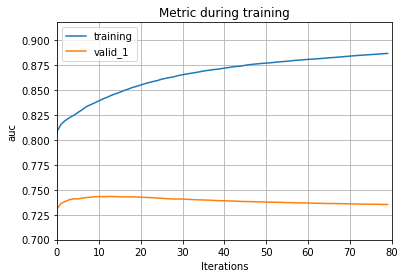

In [49]:
print('画出训练结果...')
ax = lgb.plot_metric(evals_result, metric='auc')#metric的值与之前的params里面的值对应
plt.show()


In [50]:
evals_result

{'training': OrderedDict([('auc',
               [0.808302609819095,
                0.8156851273760624,
                0.8193435209121832,
                0.8221619980432251,
                0.824545245484886,
                0.8274027512687538,
                0.8300356411044698,
                0.8331399360369417,
                0.8351016204525401,
                0.8369931606597265,
                0.8389722276838191,
                0.8410329647988207,
                0.8426612497039394,
                0.8445360200395181,
                0.8461172777728181,
                0.8475672564185927,
                0.8493668618185837,
                0.8507738796716915,
                0.8523544602554256,
                0.8535289370228153,
                0.8548489724492188,
                0.8562134833509637,
                0.8573647526412078,
                0.8584289236519238,
                0.8593675200521033,
                0.8606876897284186,
                0.86161615330157

画特征重要性排序...


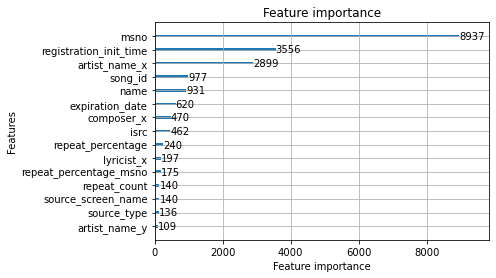

In [52]:
print('画特征重要性排序...')
ax = lgb.plot_importance(lgbm_model, max_num_features=15)#max_features表示最多展示出前10个重要性特征，可以自行设置
plt.show()


In [87]:
from sklearn.metrics import confusion_matrix

from IPython.display import display
pd.options.display.max_columns = None
#display(cm)

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    #cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

In [86]:
lists = train_features["target"].value_counts().index
print(predictions, list(lists))

[0.32715071 0.36259681 0.10393143 ... 0.18359685 0.00063664 0.00103596] [1, 0]


In [69]:
# print('Plotting split value histogram...')
# ax = lgb.plot_split_value_histogram(lgbm_model, feature='repeat_precentage', bins='auto')
# plt.show()

In [70]:
# print('Plot 3th tree...')  # 画出决策树，其中的第三颗
# ax = lgb.plot_tree(lgbm_model, tree_index=3, figsize=(20, 8), show_info=['split_gain'])
# plt.show()


In [71]:
#!conda install graphviz python-graphviz -y

In [72]:
#!sudo apt-get install graphviz

In [73]:
#!pip install graphviz==0.3.3

In [74]:
# #print('导出决策树的pdf图像到本地')#这里需要安装graphviz应用程序和python安装包
# #graph = lgb.create_tree_digraph(lgbm_model, tree_index=3, name='Tree3')

# ax = lgb.create_tree_digraph(lgbm_model, tree_index=3)
# with open('fst.svg', 'w') as f:
#     f.write(ax._repr_svg_())

# #dot.render(graph, view=True)

In [75]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [77]:
lgb_model = lgb.LGBMClassifier(n_estimators=100)



In [82]:
def get_metric(clf, X, y_true):
    y_pred = clf.predict(X)
    y_proba = clf.predict_proba(X)

    acc = metrics.accuracy_score(y_true, y_pred)
    p = metrics.precision_score(y_true, y_pred)
    r = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_proba[:, 1])
    auc = metrics.auc(fpr, tpr)
    return acc, p, r, f1, fpr, tpr, auc

scaler = StandardScaler()

X_train = train_features.drop(['target'], axis=1)
y_ = train_features['target'].values
X_train, X_test, y_train, y_test = train_test_split(X_train, y_, test_size=0.3, random_state=2018)

#X_test = test_features

# X_train = scaler.fit_transform(X)
# X_test = scaler.fit_transform(X_test)

In [83]:
fprs_train = []
tprs_train = []
aucs_train = []
fprs_test = []
tprs_test = []
aucs_test = []

lgb_model.fit(X_train, y_train)
acc, p, r, f1, fpr_train, tpr_train, auc_train = get_metric(lgb_model, X_train, y_train)
fprs_train.append(fpr_train)
tprs_train.append(tpr_train)
aucs_train.append(auc_train)

In [84]:
print(acc, p, r, f1)

0.7307052100309206 0.7330179285171478 0.7315891293980092 0.732302832024257


In [89]:
acc_t, p_t, r_t, f1_t, fpr_test, tpr_test, auc_test = get_metric(lgb_model, X_test, y_test)
fprs_test.append(fpr_test)
tprs_test.append(tpr_test)
aucs_test.append(auc_test)

In [90]:
print(acc_t, p_t, r_t, f1_t)

0.7270491129238497 0.7293776913510133 0.7282050499903105 0.7287908989692203


In [93]:
predictions[:10]

array([0.32715071, 0.36259681, 0.10393143, 0.04597941, 0.10050211,
       0.15250847, 0.16088236, 0.56351587, 0.11929213, 0.72602837])

In [97]:
# y_ = train_features['target'].values
# cm_analysis(y_, predictions, list(lists), ymap=None, figsize=(19,12))

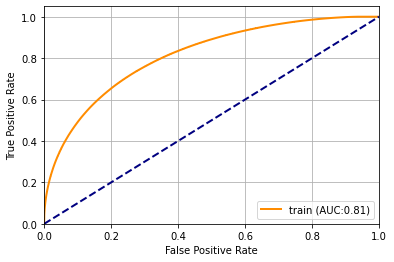

In [99]:
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange', lw=lw, label='train (AUC:%0.2f)' % auc_train)
#plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=lw, label='test (AUC:%0.2f)' % auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic of '+name)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()